# Plot some first SPECS Calculations for Eriswil


In [2]:
%matplotlib inline
%matplotlib widget

In [3]:
import json
import glob
import numpy as np
import xarray as xr

import thermodynamic_variables as td

In [4]:
from typing import Dict
import copy
import multiprocessing
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
import re
from ipywidgets import interact, widgets, fixed

HHLd = np.array(
    [21.500002  , 20.514286  , 19.556965  , 18.62768   , 17.72607   ,
    16.851786  , 16.004465  , 15.183751  , 14.389286  , 13.620715  ,
    12.87768   , 12.159819  , 11.474235  , 10.83433   , 10.231516  ,
    9.650918  ,  9.092202  ,  8.555033  ,  8.039072  ,  7.5439944 ,
    7.069464  ,  6.615141  ,  6.180692  ,  5.76579   ,  5.370097  ,
    4.993273  ,  4.634993  ,  4.294922  ,  3.9727197 ,  3.6680555 ,
    3.3805976 ,  3.110009  ,  2.855953  ,  2.6181023 ,  2.3961203 ,
    2.18967   ,  1.9984195 ,  1.8220367 ,  1.6601849 ,  1.5125275 ,
    1.3787366 ,  1.2584761 ,  1.151409  ,  1.0572032 ,  0.9755266 ,
    0.9060427 ,  0.84841454,  0.8023148 ,  0.76740676,  0.7433537 ]
    )

RGRENZ = np.array(
    [1.25992106e-09, 1.58740110e-09, 1.99999994e-09, 2.51984211e-09,
    3.17480220e-09, 3.99999989e-09, 5.03968423e-09, 6.34960440e-09,
    7.99999977e-09, 1.00793685e-08, 1.26992088e-08, 1.59999995e-08,
    2.01587369e-08, 2.53984176e-08, 3.19999991e-08, 4.03174738e-08,
    5.07968352e-08, 6.39999982e-08, 8.06349476e-08, 1.01593670e-07,
    1.27999996e-07, 1.61269895e-07, 2.03187341e-07, 2.55999993e-07,
    3.22539790e-07, 4.06374681e-07, 5.11999986e-07, 6.45079581e-07,
    8.12749363e-07, 1.02399997e-06, 1.29015916e-06, 1.62549873e-06,
    2.04799994e-06, 2.58031832e-06, 3.25099745e-06, 4.09599988e-06,
    5.16063665e-06, 6.50199490e-06, 8.19199977e-06, 1.03212733e-05,
    1.30039898e-05, 1.63839995e-05, 2.06425466e-05, 2.60079796e-05,
    3.27679991e-05, 4.12850932e-05, 5.20159592e-05, 6.55359981e-05,
    8.25701864e-05, 1.04031918e-04, 1.31071996e-04, 1.65140373e-04,
    2.08063837e-04, 2.62143993e-04, 3.30280745e-04, 4.16127674e-04,
    5.24287985e-04, 6.60561491e-04, 8.32255348e-04, 1.04857597e-03,
    1.32112298e-03, 1.66451070e-03, 2.09715194e-03, 2.64224596e-03,
    3.32902139e-03, 4.19430388e-03]
)

def format_string(s: str) -> str:
    """Formats input string to a certain format."""
    return "INP = {}, FLARE = {}".format(*re.findall(r'[0-9\.e]+', s), 'FEno' if 'FEno' in s else '') 



class MultiPanelPlot_Meteogram:
    def __init__(

        self, 
        datasets: Dict[str, xr.Dataset], 
        varname: str, 
        mode: str,         
        metadata: Dict[str, Dict] = None, # type: ignore
        timestep0: int | list = None, # type: ignore
        timeframe: str = 'single', 
        vmin: float = 1.0,      vmax: float = 1.0e4, 
        ymin: float = 0.0,      ymax: float = 12.0,
        nrows: int = 2,         ncols: int = 3, 
        hmin: float = 41,       hmax: float = 44, 

    ) -> None:
        """
        Initializer for the MultiPanelPlot class. 

        Args:
            datasets (dict of str: xr.Dataset): The dictionary of data sets for plotting.
            varname (str): The variable name in the data sets.
            mode (str): The plotting mode ('profile' or 'area').
            vmin (float, optional): The minimum value for the color bar. Defaults to 1.0.
            vmax (float, optional): The maximum value for the color bar. Defaults to 1.0e4.
            nrows (int, optional): The number of rows in the subplot. Defaults to 2.
            ncols (int, optional): The number of columns in the subplot. Defaults to 3.
            hmin (float, optional): The minimum model level height. Defaults to 42.
            hmax (float, optional): The maximum model level height. Defaults to 44.
            timeframe (str, optional): The timeframe to plot ('single' or other). Defaults to 'single'.
            xmin (float, optional): The minimum x-value. Defaults to 1.0e-9.
            xmax (float, optional): The maximum x-value. Defaults to 1.0e-2.
            ymin (float, optional): The minimum y-value. Defaults to 0.0.
            ymax (float, optional): The maximum y-value. Defaults to 12.0
            timestep0 (int or list, optional): The time step for the plot. Defaults to 0 or [0, 10]..
            metadata (Dict): Metadata from ensemble runs. Defaults None.
        """
        
        self.datasets = copy.deepcopy(datasets)
        self.varname =  varname
        self.mode = mode
        self.md = metadata
        key = next(iter(datasets))
        self.time = datasets[key].time.values
        self.height = datasets[key].HMLd.values * 1.0e-3
        self.hlim = (hmin, hmax)
        self.ylim = (ymin, ymax)
        self.timeframe = timeframe
        self.rgrenz = RGRENZ

        self.standard_name, self.unit = datasets[key][varname].attrs.values()
        self.cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'mycmap', [
                (0, 'white'), (0.2, 'blue'), (0.4, 'cyan'), (0.5, 'lime'), 
                (0.6, 'yellow'), (0.9, 'red'), (1, 'purple')
                ]
            ) 
        self.norm = colors.LogNorm(vmin, vmax)
        self.n_axes = nrows * ncols

        mpl.rcParams['font.size'] = 10
        self.pmeshs = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=(ncols*7,nrows*3.33), constrained_layout=True)
        if nrows*ncols==1:
            self.axes = np.array(self.axes)
        self.fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.15, right=0.8, top=0.85, bottom=0.15)  # make space for colorbar
        self.timestep = 0 if (timestep0 is None and timeframe == 'single') else (timestep0 if timestep0 is not None else [0, 10])
        print(self.timestep)
        
        if self.md is not None:
            for date, ax in zip(self.md.keys(), self.axes.flatten()):
                ax.set_title(f'INP = {self.md[date]["SBM_PAR.dnap_init"]},  FE = {self.md[date]["FLARE_SBM.flare_emission"]}')
                
        self._init_timeseries_plot(timestep0)       


    def set_colorbar(self) -> None:
        """
        Creates and sets a color bar for the figure.
        """
        cbar_ax = self.fig.add_axes([0.89, 0.21, 0.01, 0.6])  # adjust these values as needed
        cbar = self.fig.colorbar(
            cm.ScalarMappable(norm=self.norm, cmap=self.cmap), 
            cax=cbar_ax, 
            orientation='vertical', 
            extend='both', 
            )
        cbar.set_label(self.unit)
        self.colorbar = cbar


    def set_name_tick_params(self, ax: mpl.axes.Axes, name: str) -> None:
        """
        Sets the title and tick parameters for an axes.

        Args:
            ax (mpl.axes.Axes): The axes to configure.
            name (str): The title for the axes.
        """
        #ax.set_title(format_string(name))
        ax.tick_params(which='both', direction='in')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.25)
           


    def _init_timeseries_plot(self, timestep: int) -> None:
        """
        Initializes the timeseries plot.

        Args:
            timestep (int): The time step for the plot.
        """
        for (name, ds), ax in zip(self.datasets.items(), self.axes.flat):
            data = ds[self.varname].sum(dim='bins').T
            pcm = ax.pcolormesh(self.time, self.height, data, norm=self.norm, cmap=self.cmap)
            self.pmeshs.append(pcm)
            ax.set(ylim=self.ylim)
            self.set_name_tick_params(ax, name)
        
        self.fig.text(0.5, 0.06, 'time [step]', ha='center', va='center')
        self.fig.text(0.1, 0.5, 'height [km]', ha='center', va='center', rotation='vertical')
        self.set_colorbar()

        self.set_colorbar()


    def display(self, timestep: int = 0, x: int = 12, y: int = 12, hmin: float = 42, hmax: float = 44) -> None:
        """
        Displays the plot according to the plot mode.

        Args:
            timestep (int, optional): The time step for the plot. Defaults to 0.
            x (int, optional): The x-value for the plot. Defaults to 12.
            y (int, optional): The y-value for the plot. Defaults to 12.
            hmin (float, optional): The minimum height. Defaults to 42.
            hmax (float, optional): The maximum height. Defaults to 44.
        """

        self._display_timeseries(x=x, y=y)    
        plt.show()


    def _display_timeseries(self, x: int = 12, y: int = 12) -> None:
        """
        Displays the timeseries plot.

        Args:
            timestep (int): The time step for the plot.
            hmin (float): The minimum height.
            hmax (float): The maximum height.
        """
        for i, (name, ds) in enumerate(self.datasets.items()):
            if i < self.n_axes and self.varname in ds:
                data = ds[self.varname][:, :, :].sum(dim='bins').T
                self.pmeshs[i].set_array(data.values.ravel())                   
 
        

    def interactive(self):
        """
        Creates an interactive plot with sliders according to the plot mode.
        """
        if self.mode in ['timeseries']:
            sliders = {
                'timestep': widgets.IntSlider(min=0, max=len(self.time)-1, step=1, value=0) if self.mode == 'profile' else fixed(False),
                'hmin': fixed(False),
                'hmax': fixed(False),
                'savefig': fixed(False)
            }    
        else:
            sliders = {}
        
        interact(self.display, **sliders)
        return self


    def save_figure(self, filename: str) -> None:
        """
        Saves the figure to a file.

        Args:
            filename (str): The file name.
        """
        self.fig.savefig(filename, facecolor='white', dpi=300)




# List Available COSMO-SPECS NetCDF Output Files

In [5]:
plots_path = '/work/bb1262/user/schimmel/cosmo-specs-torch/python/plots'
data_path = '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/' # fabians project
#data_path = '/work/bb1178/schimmel/COSMO-SPECS/testcases/RUN_ERISWILL_TESTCASE01/' # roland project
meta_path = data_path + 'cs-eriswil__20230821_172639.json'

date_str = '2023020809'


file_paths = glob.glob( data_path + '*.nc' )

m_files  = sorted([path for path in file_paths if path.rsplit('/', 1)[-1].startswith("M_")])
d3_files = sorted([path for path in file_paths if path.rsplit('/', 1)[-1].startswith("3D_")])

sorted(file_paths)



['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172639.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172722.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172859.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172929.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173020.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173051.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173224.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173311.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testc

# Load files from Meta Data

In [6]:
with open(meta_path) as f:
   metadata = json.load(f)

metadata


meta_file_list = [data_path + 'M_' + file + '.nc' for file in metadata.keys()]
meta_file_list

['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_172639.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_172722.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_172859.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_172929.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_173020.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_173051.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_173224.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_20230821_173311.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN

# Read NetCDF Files

In [7]:
data = {}

# Load each file into a separate xarray Dataset and store in the dictionary
for file in meta_file_list:# + other_files:
    # Use the file name as the key
    key = file.rsplit('/', 1)[-1][:-3]
    
    # Open the dataset and assign to the dictionary
    data[key] = xr.open_mfdataset(file)#, preprocess=td.add_metadata)

list(data.keys())


['M_20230821_172639',
 'M_20230821_172722',
 'M_20230821_172859',
 'M_20230821_172929',
 'M_20230821_173020',
 'M_20230821_173051',
 'M_20230821_173224',
 'M_20230821_173311',
 'M_20230821_173350',
 'M_20230821_173420',
 'M_20230821_173511',
 'M_20230821_173542']

In [14]:
print(data['M_20230821_173511']['U'].values.min())
print(data['M_20230821_173511']['V'].values.max())

-33.405354
2.5091023


In [9]:
#data['M_20230821_173511'].plot.quiver(u=data['M_20230821_173511']['U'], v=data['M_20230821_173511']['V'])

# time: 182  z: 50  bin: 66


ValueError: Expected 'x'  must be one of (HHLd, HMLd, NF, NI, NINP, NW, PHL, PML, QC, QC_Sp, QF, QFA, QFS, QFW, QI, QIA, QI_Sp, QV, QV_Sp, QW, QWA, QWS, RGRENZ_left, RGRENZ_right, RHO, SUM_BREAN, SUM_BREAQ, SUM_CONDN, SUM_CONDNFROD, SUM_CONDQ, SUM_CONDQFROD, SUM_CONDQWFROD, SUM_HOMN, SUM_HOMQ, SUM_IMMERN, SUM_IMMERQ, SUM_KOLLN, SUM_KOLLNFROD, SUM_KOLLNFRODI, SUM_KOLLNFROD_INS, SUM_KOLLNI, SUM_KOLLN_INS, SUM_KOLLQ, SUM_KOLLQFROD, SUM_KOLLQFRODI, SUM_KOLLQFROD_INS, SUM_KOLLQI, SUM_KOLLQ_INS, SUM_N_BREAN, SUM_N_BREAQ, SUM_N_CONDN, SUM_N_CONDNFROD, SUM_N_CONDQ, SUM_N_CONDQFROD, SUM_N_CONDQWFROD, SUM_N_HOMN, SUM_N_HOMQ, SUM_N_IMMERN, SUM_N_IMMERQ, SUM_N_KOLLN, SUM_N_KOLLNFROD, SUM_N_KOLLNFRODI, SUM_N_KOLLNFROD_INS, SUM_N_KOLLNI, SUM_N_KOLLN_INS, SUM_N_KOLLQ, SUM_N_KOLLQFROD, SUM_N_KOLLQFRODI, SUM_N_KOLLQFROD_INS, SUM_N_KOLLQI, SUM_N_KOLLQ_INS, SUM_N_deponf, SUM_N_depoqf, SUM_N_dnfmelt, SUM_N_dnwmelt, SUM_N_dqffrier, SUM_N_dqfmelt, SUM_N_dqfwmelt, SUM_N_dqwmelt, SUM_N_knf, SUM_N_kollqwf, SUM_N_kqf, SUM_N_kqwf, SUM_P_BREAN, SUM_P_BREAQ, SUM_P_CONDN, SUM_P_CONDNFROD, SUM_P_CONDQ, SUM_P_CONDQFROD, SUM_P_CONDQWFROD, SUM_P_HOMN, SUM_P_HOMQ, SUM_P_IMMERN, SUM_P_IMMERQ, SUM_P_KOLLN, SUM_P_KOLLNFROD, SUM_P_KOLLNFRODI, SUM_P_KOLLNFROD_INS, SUM_P_KOLLNI, SUM_P_KOLLN_INS, SUM_P_KOLLQ, SUM_P_KOLLQFROD, SUM_P_KOLLQFRODI, SUM_P_KOLLQFROD_INS, SUM_P_KOLLQI, SUM_P_KOLLQ_INS, SUM_P_deponf, SUM_P_depoqf, SUM_P_dnfmelt, SUM_P_dnwmelt, SUM_P_dqffrier, SUM_P_dqfmelt, SUM_P_dqfwmelt, SUM_P_dqwmelt, SUM_P_knf, SUM_P_kollqwf, SUM_P_kqf, SUM_P_kqwf, SUM_deponf, SUM_depoqf, SUM_dnfmelt, SUM_dnwmelt, SUM_dqffrier, SUM_dqfmelt, SUM_dqfwmelt, SUM_dqwmelt, SUM_knf, SUM_kollqwf, SUM_kqf, SUM_kqwf, T, T2m, TKE, U, V, VF, VW, W, time). Received None instead.

# Plot a time series of a specific location

In [ ]:
plot5 = MultiPanelPlot_Meteogram(
    data, 
    metadata    = metadata,
    varname     = 'NF', 
    nrows       = 3, 
    ncols       = 4, 
    mode        = 'timeseries',
    ymin        = 0, 
    ymax        = 2
    ).interactive()

/tmp/ipykernel_2339954/1594922560.py:117: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.15, right=0.8, top=0.85, bottom=0.15)  # make space for colorbar


0


interactive(children=(IntSlider(value=12, description='x', max=36, min=-12), IntSlider(value=12, description='…

In [9]:
list(data.keys())

['M_20230821_172639',
 'M_20230821_172722',
 'M_20230821_172859',
 'M_20230821_172929',
 'M_20230821_173020',
 'M_20230821_173051',
 'M_20230821_173224',
 'M_20230821_173311',
 'M_20230821_173350',
 'M_20230821_173420',
 'M_20230821_173511',
 'M_20230821_173542']

In [10]:
data["3D_20230821_113443"]

KeyError: '3D_20230821_113443'

'mixed-phase droplet number concentration'

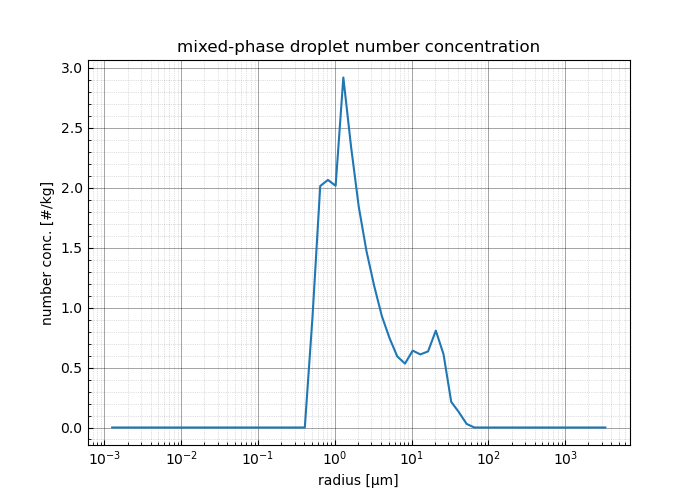

In [ ]:
date = '3D_20230821_172722'
t, h, x, y = 300, 41, 12, 12 

var = 'nf'
radius = RGRENZ * 1.0e6 # m to µm
fac = 1/np.diff(radius)
spectra = data[date][var][t, h, x, y , :-1].values*fac

var_name = data[date][var].attrs['long_name']
units = data[date][var].attrs['units']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.plot(radius[:-1], spectra)
ax.set(xlabel='radius [µm]', ylabel=f'number conc. [{units}]', title=var_name)
ax.set_xscale('log')
ax.tick_params(which='both', direction='in')
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.25)

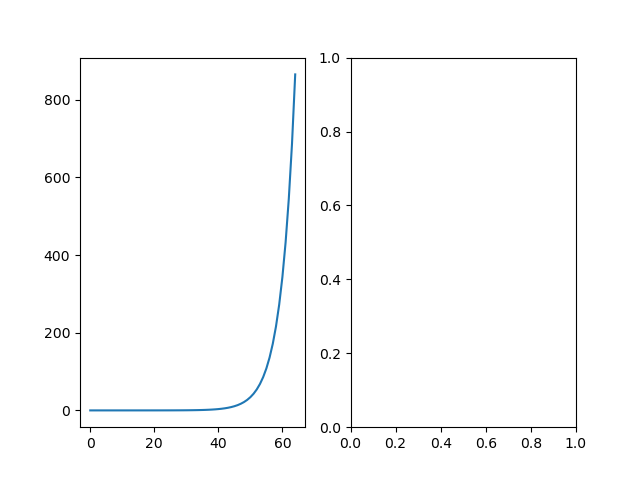

In [34]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.diff(radius))